In [19]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import time
# for importing data
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [2]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Import a dataset

In [3]:
# transformations
transform = T.Compose([ T.ToTensor(),
                        T.Normalize([.5,.5,.5],[.5,.5,.5])
                       ])

# import the data and simultaneously apply the transform
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,  download=True, transform=transform)
devtest  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# split the devtest into two separate sets
randidx = np.random.permutation(10000)   # a random permutation of indices
devset  = Subset(devtest,randidx[:6000]) # Subset for devset
testset = Subset(devtest,randidx[6000:]) # Subset for test

# transform to dataloaders
batchsize    = 32
train_loader = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
dev_loader   = DataLoader(devset,  batch_size=batchsize) # note: devtest in batches!
test_loader  = DataLoader(testset, batch_size=len(testset))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [8]:
# check out the shape of the datasets
print('Data shapes (train/dev/test):')
print( len(trainset) )
print( len(devset) )
print( len(testset) )

# and the range of pixel intensity values
print('\nData value range:')
print( (np.min(trainset.data),np.max(trainset.data)) )

# the unique categories
print('\nData categories:')
print( trainset.classes )

Data shapes (train/dev/test):
50000
6000
4000

Data value range:
(0, 255)

Data categories:
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [9]:
#Check out
X,y = next(iter(train_loader))

# try again
print('Data shapes (train/test):')
print( X.data.shape )

# and the range of pixel intensity values
print('\nData value range:')
print( (torch.min(X.data),torch.max(X.data)) )

Data shapes (train/test):
torch.Size([32, 3, 32, 32])

Data value range:
(tensor(-1.), tensor(1.))


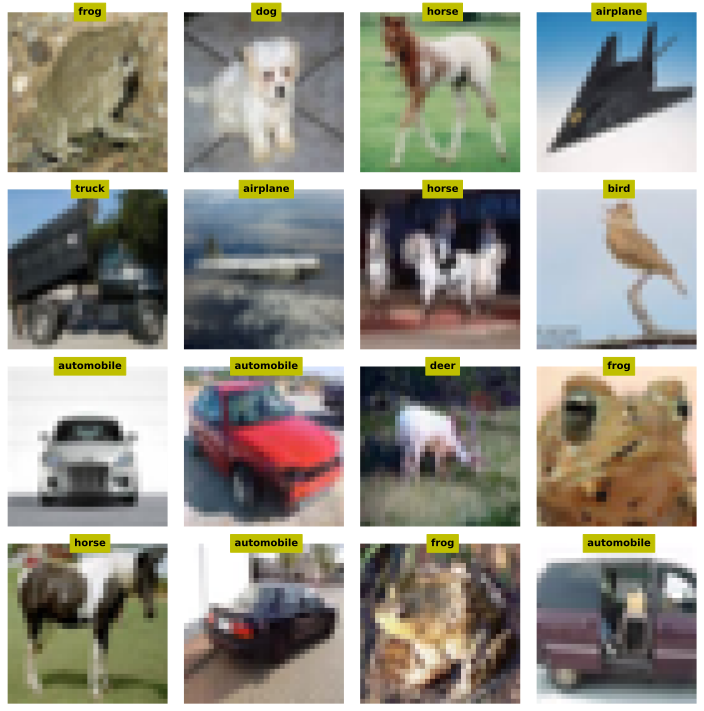

In [10]:
# inspect a few random images

fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image (need to transpose it back to 32x32x3)
  pic = X.data[i].numpy().transpose((1,2,0))
  pic = pic/2 + .5 # undo normalization
  
  # and its label
  label = trainset.classes[y[i]]

  # and show!
  ax.imshow(pic)
  ax.text(16,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

# Create the DL model

In [20]:
# create a class for the model
def makeTheNet(dropoutRate,printtoggle=False):

  class cnnnet(nn.Module):
    def __init__(self,dropoutRate,printtoggle):
      super().__init__()
      
      # print toggle
      self.print = printtoggle

      ### -------------- feature map layers -------------- ###
      # first convolution layer
      self.conv1  = nn.Conv2d(3,64,3,padding=1)
      self.bnorm1 = nn.BatchNorm2d(64) # input the number of channels in this layer
      # output size: (32+2*1-3)/1 + 1 = 32/2 = 16 (/2 b/c maxpool)

      # second convolution layer
      self.conv2  = nn.Conv2d(64,128,3)
      self.bnorm2 = nn.BatchNorm2d(128) # input the number of channels in this layer
      # output size: (16+2*0-3)/1 + 1 = 14/2 = 7 (/2 b/c maxpool)

      # third convolution layer
      self.conv3  = nn.Conv2d(128,256,3)
      self.bnorm3 = nn.BatchNorm2d(256) # input the number of channels in this layer
      # output size: (7+2*0-3)/1 + 1 = 5/2 = 2 (/2 b/c maxpool)
      
      ### -------------- linear decision layers -------------- ###
      self.fc1 = nn.Linear(2*2*256,256)
      self.fc2 = nn.Linear(256,64)
      self.fc3 = nn.Linear(64,10)
      #----------------------Drop out-------------------------###
      self.dr = dropoutRate

    def forward(self,x):
      
      if self.print: print(f'Input: {list(x.shape)}')
      
      # first block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv1(x),2)
      x = F.leaky_relu(self.bnorm1(x))
      if self.print: print(f'First CPBR block: {list(x.shape)}')

      # second block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv2(x),2)
      x = F.leaky_relu(self.bnorm2(x))
      if self.print: print(f'Second CPR block: {list(x.shape)}')

      # third block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv3(x),2)
      x = F.leaky_relu(self.bnorm3(x))
      if self.print: print(f'Third CPR block: {list(x.shape)}')

      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Vectorized: {list(x.shape)}')
      
      # linear layers
      x = F.leaky_relu(self.fc1(x))
      x = F.dropout(x,p=self.dr,training=self.training)
      x = F.leaky_relu(self.fc2(x))
      x = F.dropout(x,p=self.dr,training=self.training) # training=self.training means to turn off during eval mode
      x = self.fc3(x)
      if self.print: print(f'Final output: {list(x.shape)}')

      return x

  # create the model instance
  net = cnnnet(dropoutRate,printtoggle)
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001,weight_decay=1e-5)

  return net,lossfun,optimizer

In [21]:
# test the model with one batch
net,lossfun,optimizer = makeTheNet(0.4,True)

X,y = iter(train_loader).next()
yHat = net(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# now compute the loss
loss = lossfun(yHat,torch.squeeze(y))
print(' ')
print('Loss:')
print(loss)

Input: [32, 3, 32, 32]
First CPBR block: [32, 64, 16, 16]
Second CPR block: [32, 128, 7, 7]
Third CPR block: [32, 256, 2, 2]
Vectorized: [32, 1024]
Final output: [32, 10]

Output size:
torch.Size([32, 10])
 
Loss:
tensor(2.3045, grad_fn=<NllLossBackward0>)


# Create a function that trains the model

In [22]:

# number of epochs
numepochs = 10
# a function that trains the model
def funtion2trainTheModel(dropoutRate):

  # create a new model
  net,lossfun,optimizer = makeTheNet(dropoutRate,False)

  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  devLoss   = torch.zeros(numepochs)
  trainAcc  = torch.zeros(numepochs)
  devAcc    = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train() # switch to train mode
    batchLoss = []
    batchAcc  = []
    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and accuracy from this batch
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
    # end of batch loop...

    # and get average losses and accuracies across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi]  = 100*np.mean(batchAcc)


    #### test performance (done in batches!)
    net.eval() # switch to test mode
    batchAcc  = []
    batchLoss = []
    for X,y in dev_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      with torch.no_grad():
        yHat = net(X)
        loss = lossfun(yHat,y)
      
      # loss and accuracy from this batch
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
    # end of batch loop...

    # get average losses and accuracies across the batches
    devLoss[epochi] = np.mean(batchLoss)
    devAcc[epochi]  = 100*np.mean(batchAcc)

  # end epochs

  # function output
  return trainLoss,devLoss,trainAcc,devAcc,net

# Run the model and show the results!

Done by optimizer = 0.0
Done by optimizer = 0.1
Done by optimizer = 0.2
Done by optimizer = 0.3
Done by optimizer = 0.4
Done by optimizer = 0.5


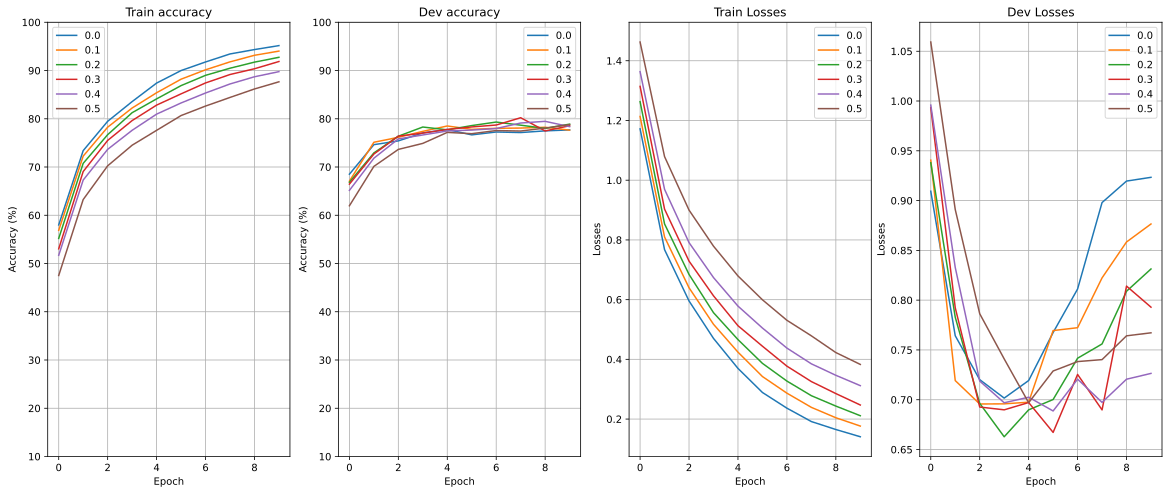

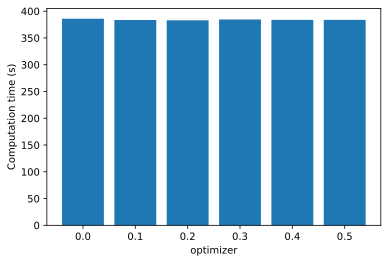

In [23]:
# ~13 minutes with 10 epochs on GPU
dropoutRates = np.arange(0,6,1)/10
trainAcc= np.zeros((numepochs,len(dropoutRates)))
trainLoss= np.zeros((numepochs,len(dropoutRates)))
devAcc = np.zeros((numepochs,len(dropoutRates)))
devLoss=np.zeros((numepochs,len(dropoutRates)))
comptime = np.zeros(len(dropoutRates))

for ai,dp in enumerate(dropoutRates):
  starttime = time.process_time()
  trainLoss[:,ai],devLoss[:,ai],trainAcc[:,ai],devAcc[:,ai],net = funtion2trainTheModel(dp)
  comptime[ai] = time.process_time() - starttime
  print("Done by drop_out rate = {}".format(dp))
  
fig,ax = plt.subplots(1,4,figsize=(20,8))

ax[0].plot(trainAcc)
ax[0].set_title('Train accuracy')
ax[1].plot(devAcc)
ax[1].set_title('Dev accuracy')
ax[2].plot(trainLoss)
ax[2].set_title('Train Losses')
ax[3].plot(devLoss)
ax[3].set_title('Dev Losses')
# common features
for i in range(2):
  ax[i].legend(dropoutRates)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([10,100])
  ax[i].grid()
for i in range(2,4):
  ax[i].legend(dropoutRates)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Losses')
  ax[i].grid()

plt.show()



# bar plot of computation time
plt.bar(range(len(comptime)),comptime,tick_label=dropoutRates)
plt.xlabel('Drop out rates')
plt.ylabel('Computation time (s)')
plt.show()
#trainLoss,devLoss,trainAcc,devAcc,net = funtion2trainTheModel()

In [30]:
dropoutRates[np.argmax(devAcc[9,:])]

0.2

In [31]:
#Finding the best number of layers by validation set
best_dr=0.2
## the real test set
trainLoss,devLoss,trainAcc,devAcc,net = funtion2trainTheModel(best_dr)
net.eval() # switch to test mode
X,y = next(iter(test_loader))

# push data to GPU
X = X.to(device)
y = y.to(device)

# forward pass and loss
with torch.no_grad():
  yHat = net(X)
  loss = lossfun(yHat,y)

# loss and accuracy from this batch
testLoss = loss.item()
testAcc  = 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item()

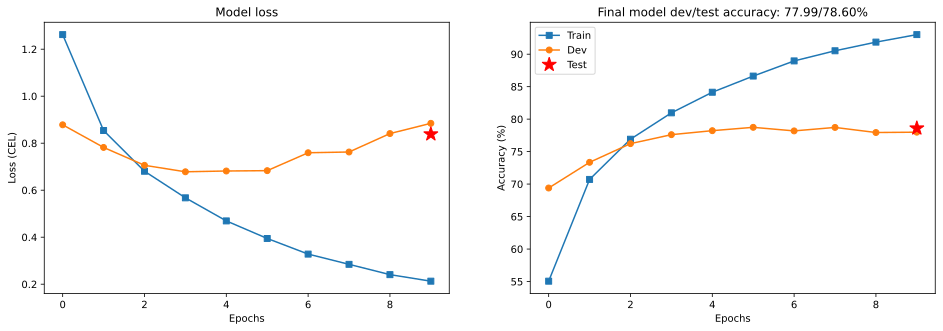

In [32]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(devLoss,'o-',label='Dev')
ax[0].plot(len(devLoss)-1,testLoss,'r*',markersize=15,label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (CEL)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(devAcc,'o-',label='Dev')
ax[1].plot(len(devAcc)-1,testAcc,'r*',markersize=15,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model dev/test accuracy: {devAcc[-1]:.2f}/{testAcc:.2f}%')
ax[1].legend()

plt.show()

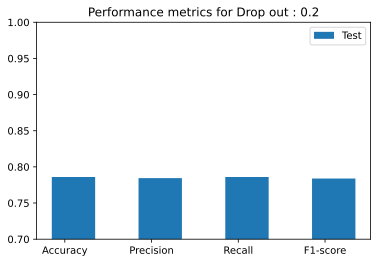

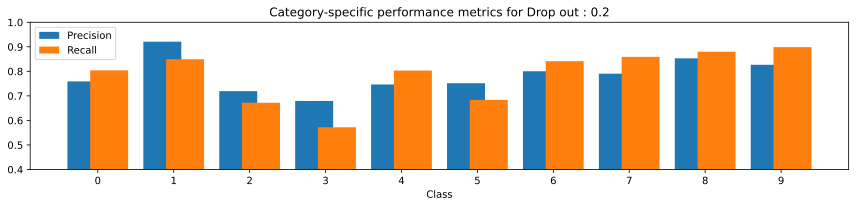

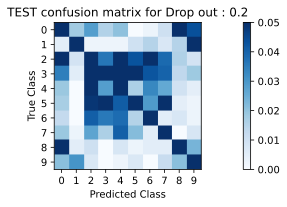

In [37]:
import sklearn.metrics as skm
test_metrics  = [0,0,0,0]
# test
y = y.to('cpu')
yHat=yHat.to('cpu')
test_predictions = torch.argmax(yHat,axis=1)
test_predictions
test_metrics[0] = skm.accuracy_score (y,test_predictions)
test_metrics[1] = skm.precision_score(y,test_predictions,average='weighted')
test_metrics[2] = skm.recall_score   (y,test_predictions,average='weighted')
test_metrics[3] = skm.f1_score       (y,test_predictions,average='weighted')
#new plot
plt.bar(np.arange(4)+.1,test_metrics,.5)
plt.xticks([0,1,2,3],['Accuracy','Precision','Recall','F1-score'])
plt.ylim([.7,1])
plt.legend(['Test'])
plt.title('Performance metrics for Drop out : {}'.format(best_dr))
#new plot
precision = skm.precision_score(y,test_predictions,average=None)
recall    = skm.recall_score   (y,test_predictions,average=None)
fig = plt.figure(figsize=(12,3))
plt.bar(np.arange(10)-.15,precision,.5)
plt.bar(np.arange(10)+.15,recall,.5)
plt.xticks(range(10),range(10))
plt.ylim([.4,1])
plt.xlabel('Class')
plt.legend(['Precision','Recall'])
plt.title('Category-specific performance metrics for Drop out : {}'.format(best_dr))
#fig.suptitle('Mini Batch of size : {}'.format(batchsizes[bi]))
plt.tight_layout()
# Confusion matrices
testConf  = skm.confusion_matrix(y,test_predictions,normalize='true')
# confmat during TEST
fig = plt.figure(figsize=(12,3))
a = plt.imshow(testConf,cmap='Blues',vmax=.05)
plt.xticks(range(10))
plt.yticks(range(10))
plt.title('TEST confusion matrix for Drop out : {}'.format(best_dr))
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
fig.colorbar(a)
#fig.suptitle('Mini Batch of size : {}'.format(batchsizes[bi]))
plt.tight_layout()
plt.show()
